In [1]:
import os
import pandas
import matplotlib.pyplot as plt
import seaborn
from tqdm import tqdm
import numpy as np

import torch
from torch import nn
from torch.optim import Adam
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms

In [2]:
class CNN_Mnist(nn.Module):
    def __init__(self):
        super(CNN_Mnist, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(64*7*7, 16),
            nn.ReLU(),
        )

        self.z_mean = nn.Linear(16, 2)
        self.z_log_var = nn.Linear(16, 2)

        self.decoder = nn.Sequential(
            nn.Linear(2, 64*7*7),
            nn.ReLU(),
            nn.Unflatten(1, (64, 7, 7)),
            nn.ConvTranspose2d(64, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=3, stride=1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        enc = self.encoder(x)
        mu = self.z_mean(enc)
        lv = self.z_log_var(enc)
        lat = self.reparam(mu, lv)
        dec = self.decoder(lat)
        
        return dec, mu, lv

    def reparam(self, mu, lv):
        std = torch.exp(0.5 * lv)
        eps = torch.randn_like(std)
        return mu + std * eps

In [3]:
transform = transforms.Compose(
    [
        transforms.ToTensor(),
    ]
)

trainset = MNIST(root='~/data', train=True, download=True, transform=transform)
train_dl = DataLoader(trainset, batch_size=128, shuffle=True, num_workers=24)
testset = MNIST(root='~/data', train=False, download=True, transform=transform)
test_dl = DataLoader(testset, batch_size=128, shuffle=False, num_workers=24)

print(len(trainset), len(testset))
print(len(train_dl), len(test_dl))

60000 10000
469 79


In [4]:
def gaussian_kls(mu, logvar):
    kld_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim=1)
    return torch.mean(kld_loss)

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu", index = 0)

model = CNN_Mnist().to(device)

optimizer = Adam(params = model.parameters(), lr = 0.001)

epochs = 100

scheduler = CosineAnnealingLR(optimizer, epochs*len(train_dl))

recon_loss = nn.BCELoss(reduction='none')

def loss_fn(recon_x, x):
    return torch.mean(torch.sum(recon_loss(recon_x, x), dim=(1,2,3)))

In [6]:
for epoch in range(epochs):
    model.train()
    tr_total_loss = {
        "rec_loss" : 0,
        "kl_loss" : 0
    }
    for train_img, _ in tqdm(train_dl):
        train_img = train_img.to(device)

        gen_img, train_mu, train_lv = model(train_img)
        train_rec_loss = loss_fn(gen_img, train_img)
        train_kl_loss = gaussian_kls(train_mu, train_lv)
        train_loss = train_rec_loss + train_kl_loss

        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

        scheduler.step()

        tr_total_loss["rec_loss"] += train_rec_loss.item()
        tr_total_loss["kl_loss"] += train_kl_loss.item()

    model.eval()
    with torch.no_grad():
        va_total_loss = {
            "rec_loss" : 0,
            "kl_loss" : 0
        }
        for valid_img, _ in tqdm(test_dl):
            valid_img = valid_img.to(device)

            gen_img, valid_mu, valid_lv = model(valid_img)
            valid_rec_loss = loss_fn(gen_img, valid_img)
            valid_kl_loss = gaussian_kls(valid_mu, valid_lv)
            valid_loss = valid_rec_loss + valid_kl_loss

            va_total_loss["rec_loss"] += valid_rec_loss.item()
            va_total_loss["kl_loss"] += valid_kl_loss.item()

    print(f"Epoch: {epoch} - TrainRecLoss: {tr_total_loss['rec_loss']/len(train_dl)} - ValidRecLoss: {va_total_loss['rec_loss']/len(test_dl)}")
    print(f"Epoch: {epoch} - TrainDivLoss: {tr_total_loss['kl_loss']/len(train_dl)} - ValidDivLoss: {va_total_loss['kl_loss']/len(test_dl)}")

100%|███████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 57.12it/s]


Epoch: 0 - TrainRecLoss: 219.2990915912555 - ValidRecLoss: 188.92529644543612
Epoch: 0 - TrainDivLoss: 3.9381491721851996 - ValidDivLoss: 3.922097423408605


100%|███████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 57.28it/s]


Epoch: 1 - TrainRecLoss: 186.82650499811558 - ValidRecLoss: 184.61677667159069
Epoch: 1 - TrainDivLoss: 4.093369436670722 - ValidDivLoss: 4.00623769397977


100%|███████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 59.14it/s]


Epoch: 2 - TrainRecLoss: 183.97744363813257 - ValidRecLoss: 182.44965932339053
Epoch: 2 - TrainDivLoss: 4.068446979848052 - ValidDivLoss: 3.9272370006464703


100%|███████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 58.08it/s]


Epoch: 3 - TrainRecLoss: 182.27499562082514 - ValidRecLoss: 181.08001361315763
Epoch: 3 - TrainDivLoss: 4.01518715063392 - ValidDivLoss: 3.9374930798252925


100%|███████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 59.48it/s]


Epoch: 4 - TrainRecLoss: 181.0691242340023 - ValidRecLoss: 179.8081292261051
Epoch: 4 - TrainDivLoss: 3.9416499986831566 - ValidDivLoss: 3.900857967666433


100%|███████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 58.51it/s]


Epoch: 5 - TrainRecLoss: 180.08820556120068 - ValidRecLoss: 178.72984468484228
Epoch: 5 - TrainDivLoss: 3.8828261996637274 - ValidDivLoss: 3.8850147271458106


100%|███████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 56.06it/s]


Epoch: 6 - TrainRecLoss: 179.26203352352704 - ValidRecLoss: 177.73918035965931
Epoch: 6 - TrainDivLoss: 3.843802280771707 - ValidDivLoss: 3.7672117510928382


100%|███████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 58.22it/s]


Epoch: 7 - TrainRecLoss: 178.4259756775553 - ValidRecLoss: 177.23249024982695
Epoch: 7 - TrainDivLoss: 3.8062448933688815 - ValidDivLoss: 3.7130348350428326


100%|███████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 59.69it/s]


Epoch: 8 - TrainRecLoss: 177.67605311021623 - ValidRecLoss: 176.7697444867484
Epoch: 8 - TrainDivLoss: 3.7950172968256446 - ValidDivLoss: 3.7177482586872728


100%|███████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 59.29it/s]


Epoch: 9 - TrainRecLoss: 176.9646929515196 - ValidRecLoss: 175.65277022349684
Epoch: 9 - TrainDivLoss: 3.7738211520953473 - ValidDivLoss: 3.7136574214017846


100%|███████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 56.30it/s]


Epoch: 10 - TrainRecLoss: 176.1892419745927 - ValidRecLoss: 174.5289772130266
Epoch: 10 - TrainDivLoss: 3.7994168216485713 - ValidDivLoss: 3.726122234441057


100%|███████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 57.63it/s]


Epoch: 11 - TrainRecLoss: 175.48176711352903 - ValidRecLoss: 174.05588348002374
Epoch: 11 - TrainDivLoss: 3.8005573042928535 - ValidDivLoss: 3.7926369226431547


100%|███████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 58.19it/s]


Epoch: 12 - TrainRecLoss: 174.8069482408861 - ValidRecLoss: 173.19916177097755
Epoch: 12 - TrainDivLoss: 3.8085502469971746 - ValidDivLoss: 3.7943878656701195


100%|███████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 59.72it/s]


Epoch: 13 - TrainRecLoss: 174.25977275010618 - ValidRecLoss: 172.6730267488504
Epoch: 13 - TrainDivLoss: 3.812760883302831 - ValidDivLoss: 3.793168587020681


100%|███████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 60.32it/s]


Epoch: 14 - TrainRecLoss: 173.56837326733034 - ValidRecLoss: 172.1541748046875
Epoch: 14 - TrainDivLoss: 3.8177694689744572 - ValidDivLoss: 3.842167763770381


100%|███████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 58.01it/s]


Epoch: 15 - TrainRecLoss: 173.0167425354915 - ValidRecLoss: 172.9798589778852
Epoch: 15 - TrainDivLoss: 3.8315402368492664 - ValidDivLoss: 3.706789134423944


100%|███████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 59.30it/s]


Epoch: 16 - TrainRecLoss: 172.4349727996631 - ValidRecLoss: 171.27289726160748
Epoch: 16 - TrainDivLoss: 3.815124591022158 - ValidDivLoss: 3.7939627955231487


100%|███████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 55.54it/s]


Epoch: 17 - TrainRecLoss: 171.97365513132578 - ValidRecLoss: 171.99549537368966
Epoch: 17 - TrainDivLoss: 3.817287798375209 - ValidDivLoss: 3.7174093662937984


100%|███████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 58.36it/s]


Epoch: 18 - TrainRecLoss: 171.5017313357355 - ValidRecLoss: 170.37330009363873
Epoch: 18 - TrainDivLoss: 3.8100153393328573 - ValidDivLoss: 3.7764527103568932


100%|███████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 59.36it/s]


Epoch: 19 - TrainRecLoss: 171.19082059229868 - ValidRecLoss: 170.07591923580895
Epoch: 19 - TrainDivLoss: 3.802916547636996 - ValidDivLoss: 3.7620054558862615


100%|███████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 59.19it/s]


Epoch: 20 - TrainRecLoss: 170.88602634584473 - ValidRecLoss: 170.3796730524377
Epoch: 20 - TrainDivLoss: 3.795638371123942 - ValidDivLoss: 3.7666499765613413


100%|███████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 58.27it/s]


Epoch: 21 - TrainRecLoss: 170.55517356888825 - ValidRecLoss: 170.19633734980715
Epoch: 21 - TrainDivLoss: 3.809580225425997 - ValidDivLoss: 3.7940280377110347


100%|███████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 55.78it/s]


Epoch: 22 - TrainRecLoss: 170.24832660862123 - ValidRecLoss: 169.33080378665198
Epoch: 22 - TrainDivLoss: 3.81236164351262 - ValidDivLoss: 3.760870004002052


100%|███████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 59.00it/s]


Epoch: 23 - TrainRecLoss: 169.9571171416911 - ValidRecLoss: 168.97102607051028
Epoch: 23 - TrainDivLoss: 3.7930882190590474 - ValidDivLoss: 3.8195464611053467


100%|███████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 58.41it/s]


Epoch: 24 - TrainRecLoss: 169.7915049473614 - ValidRecLoss: 168.60747479788864
Epoch: 24 - TrainDivLoss: 3.8022807508643504 - ValidDivLoss: 3.761596389963657


100%|███████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 58.67it/s]


Epoch: 25 - TrainRecLoss: 169.52067354442215 - ValidRecLoss: 168.75498634048654
Epoch: 25 - TrainDivLoss: 3.807188748296644 - ValidDivLoss: 3.8375445317618455


100%|███████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 58.81it/s]


Epoch: 26 - TrainRecLoss: 169.31294923957222 - ValidRecLoss: 168.33375163017948
Epoch: 26 - TrainDivLoss: 3.813602473944235 - ValidDivLoss: 3.8180740634097328


100%|███████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 59.70it/s]


Epoch: 27 - TrainRecLoss: 169.12607904690415 - ValidRecLoss: 168.44130619869958
Epoch: 27 - TrainDivLoss: 3.806029559706828 - ValidDivLoss: 3.7637311295617986


100%|███████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 59.43it/s]


Epoch: 28 - TrainRecLoss: 168.87635458354504 - ValidRecLoss: 168.37173133560373
Epoch: 28 - TrainDivLoss: 3.8142060648912053 - ValidDivLoss: 3.767777971074551


100%|███████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 58.94it/s]


Epoch: 29 - TrainRecLoss: 168.75635754680837 - ValidRecLoss: 168.04833540131773
Epoch: 29 - TrainDivLoss: 3.807726636370108 - ValidDivLoss: 3.8170017713232887


100%|███████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 58.87it/s]


Epoch: 30 - TrainRecLoss: 168.60900198930364 - ValidRecLoss: 167.9345521564725
Epoch: 30 - TrainDivLoss: 3.819674853322857 - ValidDivLoss: 3.8089605162415325


100%|███████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 59.86it/s]


Epoch: 31 - TrainRecLoss: 168.37789363901751 - ValidRecLoss: 167.66241570967662
Epoch: 31 - TrainDivLoss: 3.821937816229456 - ValidDivLoss: 3.8074979631206656


100%|███████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 59.32it/s]


Epoch: 32 - TrainRecLoss: 168.14014072052197 - ValidRecLoss: 168.0181575726859
Epoch: 32 - TrainDivLoss: 3.8378892488825294 - ValidDivLoss: 3.8466152631783785


100%|███████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 58.80it/s]


Epoch: 33 - TrainRecLoss: 168.02675916594484 - ValidRecLoss: 167.5200148956685
Epoch: 33 - TrainDivLoss: 3.848882313730366 - ValidDivLoss: 3.8053850161878366


100%|███████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 57.02it/s]


Epoch: 34 - TrainRecLoss: 167.85570273978877 - ValidRecLoss: 167.4680633544922
Epoch: 34 - TrainDivLoss: 3.834845925699165 - ValidDivLoss: 3.837438513961019


100%|███████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 59.25it/s]


Epoch: 35 - TrainRecLoss: 167.7140237771626 - ValidRecLoss: 167.74841694892208
Epoch: 35 - TrainDivLoss: 3.846370006675151 - ValidDivLoss: 3.844056533861764


100%|███████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 59.34it/s]


Epoch: 36 - TrainRecLoss: 167.55971980959114 - ValidRecLoss: 167.54683694960195
Epoch: 36 - TrainDivLoss: 3.8707268283819594 - ValidDivLoss: 3.8276762690725206


100%|███████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 58.34it/s]


Epoch: 37 - TrainRecLoss: 167.55370895288138 - ValidRecLoss: 167.55455229553996
Epoch: 37 - TrainDivLoss: 3.835762353848293 - ValidDivLoss: 3.8571001547801345


100%|███████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 60.26it/s]


Epoch: 38 - TrainRecLoss: 167.33067412874593 - ValidRecLoss: 167.8843999935102
Epoch: 38 - TrainDivLoss: 3.8714485753065486 - ValidDivLoss: 3.8248502936544297


100%|███████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 59.22it/s]


Epoch: 39 - TrainRecLoss: 167.16588760083164 - ValidRecLoss: 166.98714051065565
Epoch: 39 - TrainDivLoss: 3.879130716771205 - ValidDivLoss: 3.8446005084846595


100%|███████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 59.55it/s]


Epoch: 40 - TrainRecLoss: 167.02898642859225 - ValidRecLoss: 167.11734240568137
Epoch: 40 - TrainDivLoss: 3.866467049381118 - ValidDivLoss: 3.8887808322906494


100%|███████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 57.08it/s]


Epoch: 41 - TrainRecLoss: 166.92699391704633 - ValidRecLoss: 166.6213405947142
Epoch: 41 - TrainDivLoss: 3.8889907473948466 - ValidDivLoss: 3.877402477626559


100%|███████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 59.55it/s]


Epoch: 42 - TrainRecLoss: 166.82125864252606 - ValidRecLoss: 166.856648891787
Epoch: 42 - TrainDivLoss: 3.8893136546047513 - ValidDivLoss: 3.8900702331639545


100%|███████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 57.61it/s]


Epoch: 43 - TrainRecLoss: 166.69031819097523 - ValidRecLoss: 166.6485866112045
Epoch: 43 - TrainDivLoss: 3.905524818119464 - ValidDivLoss: 3.8950151340870915


100%|███████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 57.61it/s]


Epoch: 44 - TrainRecLoss: 166.66429616444145 - ValidRecLoss: 166.62864743003362
Epoch: 44 - TrainDivLoss: 3.8943107733085975 - ValidDivLoss: 3.9086277696150766


100%|███████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 59.39it/s]


Epoch: 45 - TrainRecLoss: 166.45069068632145 - ValidRecLoss: 166.3986688927759
Epoch: 45 - TrainDivLoss: 3.9083817239000855 - ValidDivLoss: 3.8922290802001953


100%|███████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 57.49it/s]


Epoch: 46 - TrainRecLoss: 166.35040559748342 - ValidRecLoss: 166.92207027387016
Epoch: 46 - TrainDivLoss: 3.9111281224151155 - ValidDivLoss: 3.8723999307125427


100%|███████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 58.50it/s]


Epoch: 47 - TrainRecLoss: 166.31438249209796 - ValidRecLoss: 166.2446572991866
Epoch: 47 - TrainDivLoss: 3.9218425155956864 - ValidDivLoss: 3.912408128569398


100%|███████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 57.83it/s]


Epoch: 48 - TrainRecLoss: 166.16627873337345 - ValidRecLoss: 166.51164863683002
Epoch: 48 - TrainDivLoss: 3.9286150632382455 - ValidDivLoss: 3.9164636557615258


100%|███████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 59.30it/s]


Epoch: 49 - TrainRecLoss: 166.08148007911404 - ValidRecLoss: 166.1447031528135
Epoch: 49 - TrainDivLoss: 3.9243210226233836 - ValidDivLoss: 3.899632973007009


100%|███████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 58.64it/s]


Epoch: 50 - TrainRecLoss: 165.99311005484574 - ValidRecLoss: 167.0324633634543
Epoch: 50 - TrainDivLoss: 3.925662862212419 - ValidDivLoss: 3.93894758103769


100%|███████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 57.43it/s]


Epoch: 51 - TrainRecLoss: 165.87486839701117 - ValidRecLoss: 166.12996161738528
Epoch: 51 - TrainDivLoss: 3.9353279304911077 - ValidDivLoss: 3.9347366019140315


100%|███████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 57.79it/s]


Epoch: 52 - TrainRecLoss: 165.8024696724247 - ValidRecLoss: 166.04761572729183
Epoch: 52 - TrainDivLoss: 3.9364482329598367 - ValidDivLoss: 3.9327531917185725


100%|███████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 59.31it/s]


Epoch: 53 - TrainRecLoss: 165.7202382036872 - ValidRecLoss: 166.1381747088855
Epoch: 53 - TrainDivLoss: 3.951082573262359 - ValidDivLoss: 3.9382862984379634


100%|███████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 58.98it/s]


Epoch: 54 - TrainRecLoss: 165.71150884241945 - ValidRecLoss: 166.45485059520865
Epoch: 54 - TrainDivLoss: 3.95642390383332 - ValidDivLoss: 3.936656900599033


100%|███████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 57.68it/s]


Epoch: 55 - TrainRecLoss: 165.58893378609534 - ValidRecLoss: 166.08450413957428
Epoch: 55 - TrainDivLoss: 3.967875212748676 - ValidDivLoss: 3.9556547358066223


100%|███████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 57.57it/s]


Epoch: 56 - TrainRecLoss: 165.4680366760124 - ValidRecLoss: 165.84661478935917
Epoch: 56 - TrainDivLoss: 3.971740323089079 - ValidDivLoss: 3.9545403402062913


100%|███████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 59.64it/s]


Epoch: 57 - TrainRecLoss: 165.41307679524044 - ValidRecLoss: 166.23686353466178
Epoch: 57 - TrainDivLoss: 3.97552447735882 - ValidDivLoss: 3.972227570376819


100%|███████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 53.66it/s]


Epoch: 58 - TrainRecLoss: 165.31373732837278 - ValidRecLoss: 166.0308285483831
Epoch: 58 - TrainDivLoss: 3.958600497703308 - ValidDivLoss: 3.91511965401565


100%|███████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 55.98it/s]


Epoch: 59 - TrainRecLoss: 165.26021518991953 - ValidRecLoss: 165.7908572426325
Epoch: 59 - TrainDivLoss: 3.9804330792254223 - ValidDivLoss: 3.9534206028226055


100%|███████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 57.71it/s]


Epoch: 60 - TrainRecLoss: 165.1988421930179 - ValidRecLoss: 165.75103373467167
Epoch: 60 - TrainDivLoss: 3.9765364178208147 - ValidDivLoss: 3.959974488125572


100%|███████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 54.30it/s]


Epoch: 61 - TrainRecLoss: 165.07064575325452 - ValidRecLoss: 165.86283043970036
Epoch: 61 - TrainDivLoss: 3.989030317965347 - ValidDivLoss: 3.9906506719468515


100%|███████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 52.74it/s]


Epoch: 62 - TrainRecLoss: 165.04973070352062 - ValidRecLoss: 165.71873126452482
Epoch: 62 - TrainDivLoss: 3.988876681846342 - ValidDivLoss: 3.9902739434302608


100%|███████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 51.99it/s]


Epoch: 63 - TrainRecLoss: 164.96934759794777 - ValidRecLoss: 165.7811312132244
Epoch: 63 - TrainDivLoss: 3.9961203207085125 - ValidDivLoss: 4.012079145334944


100%|███████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 53.85it/s]


Epoch: 64 - TrainRecLoss: 164.9023111827338 - ValidRecLoss: 165.6473572163642
Epoch: 64 - TrainDivLoss: 4.0085389456515115 - ValidDivLoss: 3.997907466526273


100%|███████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 56.02it/s]


Epoch: 65 - TrainRecLoss: 164.8400163792852 - ValidRecLoss: 165.6643093447142
Epoch: 65 - TrainDivLoss: 4.0030089431225875 - ValidDivLoss: 3.9861762221855455


100%|███████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 56.21it/s]


Epoch: 66 - TrainRecLoss: 164.7628522275099 - ValidRecLoss: 165.71235502218897
Epoch: 66 - TrainDivLoss: 3.9977611173698895 - ValidDivLoss: 4.006191890450973


100%|███████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 57.63it/s]


Epoch: 67 - TrainRecLoss: 164.70651245117188 - ValidRecLoss: 165.70406022856508
Epoch: 67 - TrainDivLoss: 4.012575223755989 - ValidDivLoss: 3.99103142339972


100%|███████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 54.69it/s]


Epoch: 68 - TrainRecLoss: 164.66192265817605 - ValidRecLoss: 165.6098909015897
Epoch: 68 - TrainDivLoss: 4.011676558045182 - ValidDivLoss: 4.003209811222704


100%|███████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 54.29it/s]


Epoch: 69 - TrainRecLoss: 164.6068496541428 - ValidRecLoss: 165.3848208656794
Epoch: 69 - TrainDivLoss: 4.021683229312205 - ValidDivLoss: 4.0281609432606755


100%|███████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 52.39it/s]


Epoch: 70 - TrainRecLoss: 164.57892626536682 - ValidRecLoss: 165.29651400409168
Epoch: 70 - TrainDivLoss: 4.028992184697946 - ValidDivLoss: 4.019897729535646


100%|███████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 51.42it/s]


Epoch: 71 - TrainRecLoss: 164.4928674108184 - ValidRecLoss: 165.55674338038963
Epoch: 71 - TrainDivLoss: 4.023923298443304 - ValidDivLoss: 4.00998065139674


100%|███████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 56.51it/s]


Epoch: 72 - TrainRecLoss: 164.49641805620337 - ValidRecLoss: 165.44543360456635
Epoch: 72 - TrainDivLoss: 4.023511024934651 - ValidDivLoss: 4.02436121506027


100%|███████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 56.06it/s]


Epoch: 73 - TrainRecLoss: 164.384904841116 - ValidRecLoss: 165.35846410823774
Epoch: 73 - TrainDivLoss: 4.029569060055177 - ValidDivLoss: 4.019697913640662


100%|███████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 57.02it/s]


Epoch: 74 - TrainRecLoss: 164.3720227467226 - ValidRecLoss: 165.26230882089348
Epoch: 74 - TrainDivLoss: 4.029018142838468 - ValidDivLoss: 4.023672743688656


100%|███████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 54.10it/s]


Epoch: 75 - TrainRecLoss: 164.33085238653968 - ValidRecLoss: 165.36124352563786
Epoch: 75 - TrainDivLoss: 4.035423832915739 - ValidDivLoss: 4.033634901046753


100%|███████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 54.72it/s]


Epoch: 76 - TrainRecLoss: 164.25932533247894 - ValidRecLoss: 165.26835014246686
Epoch: 76 - TrainDivLoss: 4.039532870880322 - ValidDivLoss: 4.022437756574607


100%|███████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 52.14it/s]


Epoch: 77 - TrainRecLoss: 164.25508817172508 - ValidRecLoss: 165.25668817834008
Epoch: 77 - TrainDivLoss: 4.035814923264071 - ValidDivLoss: 4.042570642278164


100%|███████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 51.53it/s]


Epoch: 78 - TrainRecLoss: 164.18599643991953 - ValidRecLoss: 165.19805251495748
Epoch: 78 - TrainDivLoss: 4.042614496593028 - ValidDivLoss: 4.040513343448881


100%|███████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 53.71it/s]


Epoch: 79 - TrainRecLoss: 164.15894703163522 - ValidRecLoss: 165.25159135649477
Epoch: 79 - TrainDivLoss: 4.043944426945278 - ValidDivLoss: 4.043282756322546


100%|███████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 57.21it/s]


Epoch: 80 - TrainRecLoss: 164.14202278966843 - ValidRecLoss: 165.18720815151553
Epoch: 80 - TrainDivLoss: 4.043006819702669 - ValidDivLoss: 4.030317309536511


100%|███████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 58.76it/s]


Epoch: 81 - TrainRecLoss: 164.11646545670433 - ValidRecLoss: 165.1248476052586
Epoch: 81 - TrainDivLoss: 4.0437160875243165 - ValidDivLoss: 4.043421805659427


100%|███████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 53.99it/s]


Epoch: 82 - TrainRecLoss: 164.0616452149999 - ValidRecLoss: 165.1177891598472
Epoch: 82 - TrainDivLoss: 4.04960910902857 - ValidDivLoss: 4.0368551000764095


100%|███████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 51.48it/s]


Epoch: 83 - TrainRecLoss: 164.06831740519638 - ValidRecLoss: 165.24913044217266
Epoch: 83 - TrainDivLoss: 4.045724240447412 - ValidDivLoss: 4.039791454242755


100%|███████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 53.84it/s]


Epoch: 84 - TrainRecLoss: 164.0151259497539 - ValidRecLoss: 165.15586041800583
Epoch: 84 - TrainDivLoss: 4.054950327761392 - ValidDivLoss: 4.043645786333688


100%|███████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 52.67it/s]


Epoch: 85 - TrainRecLoss: 163.98532052436616 - ValidRecLoss: 165.10027458094342
Epoch: 85 - TrainDivLoss: 4.056229417003802 - ValidDivLoss: 4.048880329614954


100%|███████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 51.74it/s]


Epoch: 86 - TrainRecLoss: 163.9720015535985 - ValidRecLoss: 165.14171803148486
Epoch: 86 - TrainDivLoss: 4.05789142020984 - ValidDivLoss: 4.046460073205489


100%|███████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 54.08it/s]


Epoch: 87 - TrainRecLoss: 163.9342961748526 - ValidRecLoss: 165.07675325417821
Epoch: 87 - TrainDivLoss: 4.05679988861084 - ValidDivLoss: 4.0420203239102905


100%|███████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 56.84it/s]


Epoch: 88 - TrainRecLoss: 163.91800759646938 - ValidRecLoss: 165.08941128887707
Epoch: 88 - TrainDivLoss: 4.054983295103126 - ValidDivLoss: 4.043396249602113


100%|███████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 55.90it/s]


Epoch: 89 - TrainRecLoss: 163.89412095450135 - ValidRecLoss: 165.03434927252275
Epoch: 89 - TrainDivLoss: 4.055226519672093 - ValidDivLoss: 4.046041856838178


100%|███████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 55.84it/s]


Epoch: 90 - TrainRecLoss: 163.90032913435752 - ValidRecLoss: 165.03881642788272
Epoch: 90 - TrainDivLoss: 4.055347893029642 - ValidDivLoss: 4.0481559596484225


100%|███████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 51.98it/s]


Epoch: 91 - TrainRecLoss: 163.88529272018465 - ValidRecLoss: 165.08347330214102
Epoch: 91 - TrainDivLoss: 4.056568461440519 - ValidDivLoss: 4.050691689117046


100%|███████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 50.98it/s]


Epoch: 92 - TrainRecLoss: 163.8348998372743 - ValidRecLoss: 165.0219908122775
Epoch: 92 - TrainDivLoss: 4.05934383315064 - ValidDivLoss: 4.048124702670906


100%|███████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 52.28it/s]


Epoch: 93 - TrainRecLoss: 163.85507498214494 - ValidRecLoss: 165.1056590019902
Epoch: 93 - TrainDivLoss: 4.058279204216085 - ValidDivLoss: 4.050813771501372


100%|███████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 54.19it/s]


Epoch: 94 - TrainRecLoss: 163.8617351670255 - ValidRecLoss: 165.06558150279372
Epoch: 94 - TrainDivLoss: 4.059435700048516 - ValidDivLoss: 4.051178524765787


100%|███████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 57.03it/s]


Epoch: 95 - TrainRecLoss: 163.84370155578483 - ValidRecLoss: 165.15126095542425
Epoch: 95 - TrainDivLoss: 4.060352815493846 - ValidDivLoss: 4.0525898933410645


100%|███████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 57.36it/s]


Epoch: 96 - TrainRecLoss: 163.82160246956832 - ValidRecLoss: 165.0871931631354
Epoch: 96 - TrainDivLoss: 4.060474749567158 - ValidDivLoss: 4.052146802974653


100%|███████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 54.13it/s]


Epoch: 97 - TrainRecLoss: 163.818087124367 - ValidRecLoss: 165.0474961679193
Epoch: 97 - TrainDivLoss: 4.061037491125338 - ValidDivLoss: 4.0530596171753315


100%|███████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 53.31it/s]


Epoch: 98 - TrainRecLoss: 163.83164171166004 - ValidRecLoss: 165.0868412452408
Epoch: 98 - TrainDivLoss: 4.060676030258634 - ValidDivLoss: 4.053018527694896


100%|███████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 52.92it/s]

Epoch: 99 - TrainRecLoss: 163.80474524914837 - ValidRecLoss: 165.03914632676523
Epoch: 99 - TrainDivLoss: 4.0608591113263355 - ValidDivLoss: 4.052956626385073


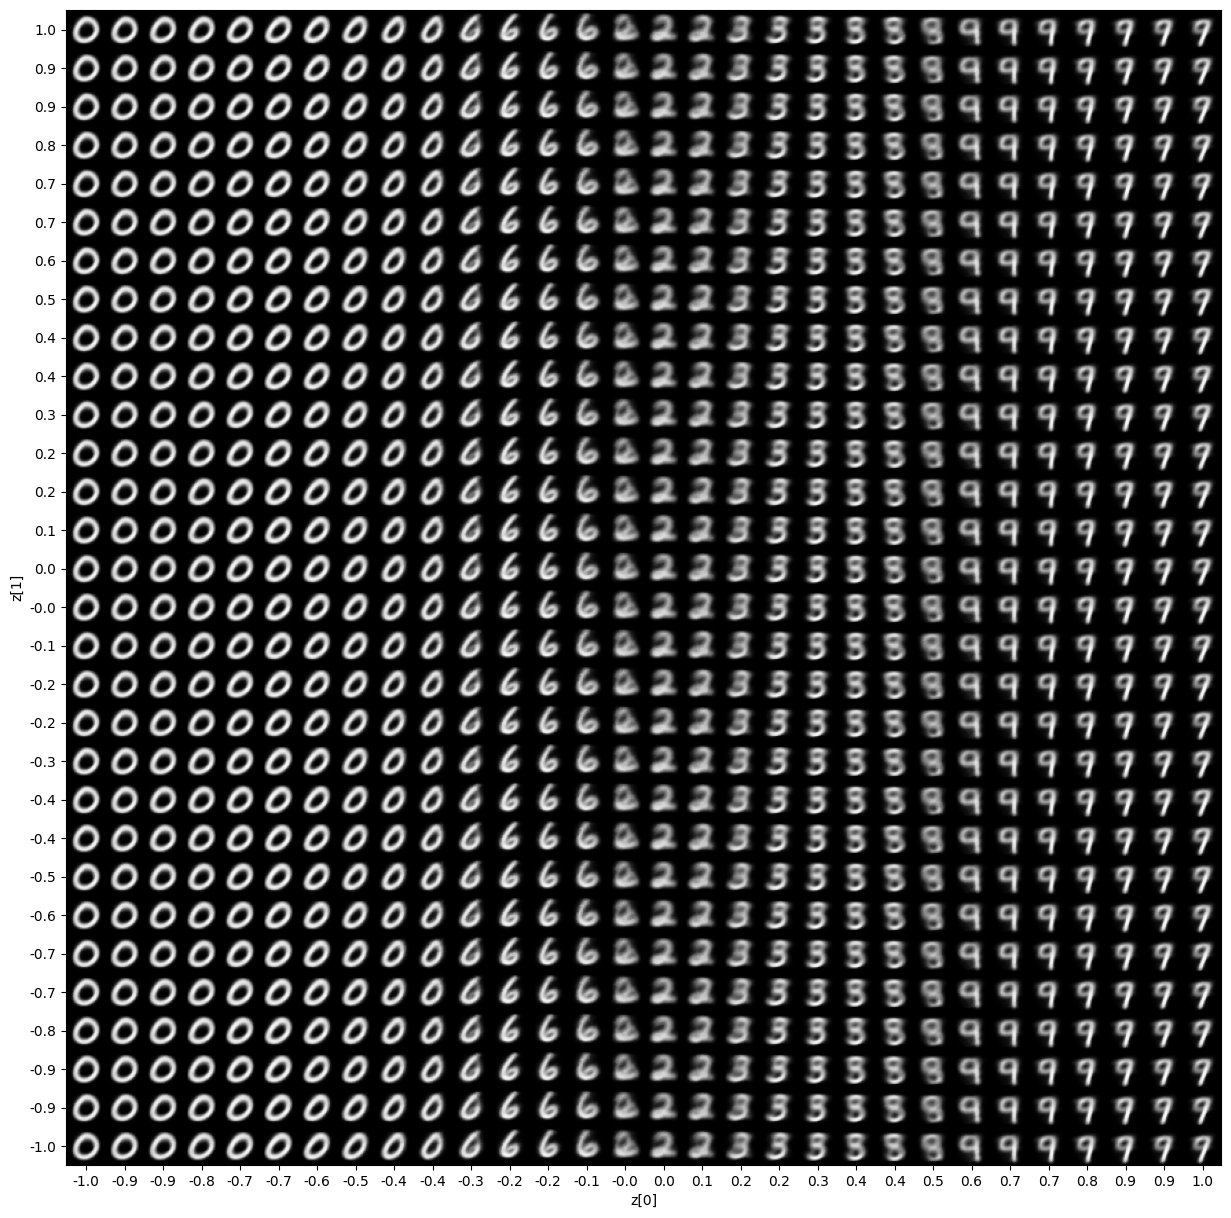

In [7]:
digit_size = 28
scale = 1.0
n = 30
figure = np.zeros((digit_size * n, digit_size * n))

grid_x = np.linspace(-scale, scale, n)
grid_y = np.linspace(-scale, scale, n)[::-1]

for i, yi in enumerate(grid_y):
    for j, xi in enumerate(grid_x):
        z_sample = torch.tensor([[xi, yi]]).to(device, dtype=torch.float)
        x_decoded = model.decoder(z_sample)
        digit = x_decoded[0].detach().cpu().numpy()
        figure[
            i * digit_size : (i + 1) * digit_size,
            j * digit_size : (j + 1) * digit_size,
        ] = digit

plt.figure(figsize=(15, 15))
start_range = digit_size // 2
end_range = n * digit_size + start_range
pixel_range = np.arange(start_range, end_range, digit_size)
sample_range_x = np.round(grid_x, 1)
sample_range_y = np.round(grid_y, 1)
plt.xticks(pixel_range, sample_range_x) 
plt.yticks(pixel_range, sample_range_y)
plt.xlabel("z[0]")
plt.ylabel("z[1]")
plt.imshow(figure, cmap="Greys_r")
plt.show()